In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import get_existing_sessions, get_session_selection, SessionDirectory
from toolkit.analysis.statistics import quantize_nd, statistic_in_grid, range_by_iqr
from toolkit.plots.plots import heatmap_in_grid
from toolkit.plots.format import format_text, SAVE_FIGURE, save_figure

## Config

In [2]:
config_name = 'mixed_stimuli_all_units_all_layers_2-100Hz'

In [3]:
session_set = 'selected'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

## Get heatmap data from session

In [4]:
power_dss = {}
n_units = {}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    if not session_dir.exist:
        print(f"Failed to load session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Skip loading session {session_id}: no lfp data")
    else:
        session_parameters = session_dir.load_population_vector_parameters(config_name=config_name)
        n_units[session_id] = session_parameters['n_units']
        if 'n_main_pc' in session_parameters:
            power_dss[session_id] = session_dir.load_population_vector_data(config_name=config_name)
        else:
            print(f"Session {session_id} does not have enough units ({n_units[session_id]}) for PCA analysis.")

print("Variable names: ", power_dss[session_id].variable_name.values)
combine_stimulus_name = power_dss[session_id].attrs['stimulus']

n_units = pd.Series(n_units)

Variable names:  ['mean_fr' 'rms_fr' 'length' 'speed' 'angle' 'radial' 'tangent']


## Plot heatmaps

In [5]:
x_var = 'radial'
y_var = 'tangent'

weighted = True
n_iqr = [1.5, 1.5]  # value range limited by outlier in term of multiple of interquartile
# n_iqr = np.inf  # no value range limit

n_bins = 10
figsize = (12, 5)

signed_var = {'radial'}

In [6]:
heatmap_ds = {}
bin_edges = {}
for session_id, power_ds in power_dss.items():
    # get quantile grids and average power in grids
    power = power_ds.power.transpose('wave_band', 'sample').values
    idx_in_grid, (x_bins, y_bins), hist_count = quantize_nd([power_ds[x_var], power_ds[y_var]], n_bins=n_bins)
    power_avg, hist_count = statistic_in_grid(power, idx_in_grid, hist_counts=hist_count)

    bins = dict(x_bin=range(x_bins.size - 1), y_bin=range(y_bins.size - 1))
    heatmap_ds[session_id] = xr.Dataset(
        data_vars=dict(
            power=(('wave_band', 'x_bin', 'y_bin'), power_avg),
            hist_count=(('x_bin', 'y_bin'), hist_count)
        ),
        coords=dict(
            wave_band=power_ds.coords['wave_band'],
            x_bin=range(x_bins.size - 1), y_bin=range(y_bins.size - 1)
        )
    )
    bin_edges[session_id] = xr.Dataset(
        data_vars=dict(
            x_edges=('x_bin', x_bins),
            y_edges=('y_bin', y_bins)
        ),
        coords=dict(x_bin=range(x_bins.size), y_bin=range(y_bins.size))
    )
heatmap_ds = xr.concat(heatmap_ds.values(), dim=pd.Index(heatmap_ds, name='session'))
bin_edges = xr.concat(bin_edges.values(), dim=pd.Index(bin_edges, name='session'))

wave_bands = power_ds.coords['wave_band'].values
n_waves = wave_bands.size
xlabel, ylabel = power_ds.label.sel(variable_name=[x_var, y_var]).values
xticks_fmt, yticks_fmt = power_ds.fmt.sel(variable_name=[x_var, y_var]).values

### Compile data from all sessions

In [7]:
if weighted:
    # average power weighted by count proportion of each bin in each session
    weights = heatmap_ds.hist_count.transpose('session', 'x_bin', 'y_bin')
    weights = weights / weights.sum(dim=['x_bin', 'y_bin'])  # proportion of bin in each session
    weights.values[:, ~weights.all(dim='session').values] = 1.0  # equal weights for bins with no count in all sessions
    avg_pow = heatmap_ds.power.weighted(weights).mean(dim='session') # weighted average
else:
    # unweighted average power
    avg_pow = heatmap_ds.power.mean(dim='session')  # average

In [8]:
# Annotation kwargs for average zero location
avg_zero_annot_kwargs = dict(
    x = dict(
        xy = [0, 0], xytext = (1, -0.05),
        ha = 'right', va = 'top', rotation = 0
    ),
    y = dict(
        xy = [0, 0], xytext = (-0.05, 0),
        ha = 'right', va = 'bottom', rotation = 90
    )
)

# Get average location of zero value of signed variable
for ax, v in zip('xy', [x_var, y_var]):
    if v in signed_var:
        edges = bin_edges[ax + '_edges']
        bins = bin_edges.coords[ax + '_bin'].values
        bins = bins / bins[-1]
        avg_zero_bin = np.mean([np.interp(0, edges.sel(session=i), bins) \
            for i in bin_edges.coords['session'].values])
        avg_zero_annot_kwargs[ax]['xy']['xy'.index(ax)] = avg_zero_bin
    else:
        avg_zero_annot_kwargs[ax] = None

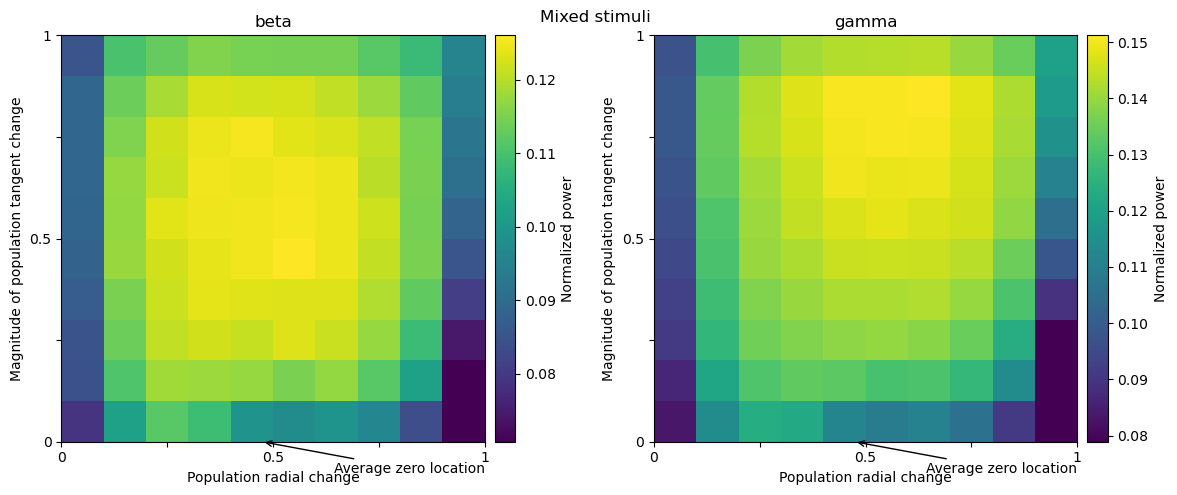

In [9]:
nticks = 5  # number of ticks on the axes
tick_locator = plt.LinearLocator(numticks=nticks)

x_bins, y_bins = bin_edges.coords['x_bin'].values, bin_edges.coords['y_bin'].values
x_bins, y_bins = x_bins / x_bins[-1], y_bins / y_bins[-1]

fig, axs = plt.subplots(1, 2, figsize=figsize)
for ax, w in zip(axs, wave_bands):
    C = avg_pow.sel(wave_band=w).values
    vmin, vmax = range_by_iqr(C, n_iqr=n_iqr)
    pcm, _ = heatmap_in_grid(C, x_bins, y_bins, vmin=vmin, vmax=vmax,
        xticks_fmt='{:g}', yticks_fmt='{:g}', even_grid=False, ax=ax)
    plt.colorbar(mappable=pcm, ax=ax, label='Normalized power', pad=0.02)
    for kwargs in avg_zero_annot_kwargs.values():
        if kwargs is not None:
            ax.annotate(f'Average zero location', fontsize=10,
                arrowprops=dict(arrowstyle='->', color='k'), **kwargs)
    ax.get_xaxis().set_major_locator(tick_locator)
    ax.get_yaxis().set_major_locator(tick_locator)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(w)
plt.tight_layout()
fig.suptitle(format_text(combine_stimulus_name))
plt.show()

## Save figures

In [10]:
# Average power heatmap
if SAVE_FIGURE:
    from toolkit.paths.paths import FIGURE_DIR

    var_str = f"{y_var}-{x_var}"
    session_set_name = f'{session_set}_sessions'

    config_dir = FIGURE_DIR / "population_vector" / config_name
    config_dir.mkdir(parents=True, exist_ok=True)

    save_figure(config_dir, fig, f"{var_str}_{session_set_name}")

In [11]:
# Individual sessions power heatmap
if SAVE_FIGURE and session_set == 'all':  # save only when running for all sessions
    heatmap_dir = config_dir / var_str
    heatmap_dir.mkdir(parents=True, exist_ok=True)

    for session_id in heatmap_ds.coords['session'].values:
        ds = heatmap_ds.sel(session=session_id)
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        x_bins = bin_edges.sel(session=session_id).x_edges
        y_bins = bin_edges.sel(session=session_id).y_edges
        for ax, w in zip(axs, wave_bands):
            pcm, _ = heatmap_in_grid(ds.power.sel(wave_band=w).values, x_bins, y_bins,
                xticks_fmt=xticks_fmt, yticks_fmt=yticks_fmt, even_grid=True, ax=ax)
            plt.colorbar(mappable=pcm, ax=ax, label='Normalized power', pad=0.02)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(w)
        fig.suptitle(f"Session {session_id:d}")
        fig.tight_layout()

        save_figure(heatmap_dir, fig, f"session_{session_id}")
        plt.close(fig)